# AI 201 Programming Assignment 2
## Naive Bayes Spam Filter Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from collections import defaultdict, Counter

In [2]:
# Notebook Constants

PATH_TO_TREC06 = "trec06p-ai201/"
TOP_N_WORDS = 200

In [3]:
def read_labels(base_path):
    # Path to the labels file
    labels_path = os.path.join(base_path, "labels")

    labels_dict = {}
    with open(labels_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                label, file_path = parts
                # Don't include ".." which is a prefix in the labels file
                file_path = file_path[3:]
                labels_dict[file_path] = label
                
    return labels_dict

def tokenize(text):
    
    return re.findall(r"[a-zA-Z]+", text.lower())

def read_documents(base_path, labels_dict):
    X = []  # List to store document contents
    Y = []  # List to store labels
    
    # Root directory for documents
    data_dir = os.path.join(base_path, "data")

    # Iterate through all subdirectories
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                relative_path = os.path.relpath(file_path, base_path)
                if relative_path in labels_dict:
                    with open(file_path, "r", errors="ignore") as f:
                        content = f.read()
                        
                    # Tokenization
                    words = tokenize(content)
                    
                    X.append(words)
                    Y.append(1 if labels_dict[relative_path] == "spam" else 0)
                    
    return X, Y

def read_trec06_corpus(base_path):
    # Get labels
    labels_dict = read_labels(base_path)
                
    # Get features
    X, Y = read_documents(base_path, labels_dict)

    return X, Y

## Store features in X and labels in Y

In [4]:
X, Y = read_trec06_corpus(PATH_TO_TREC06)

# Sanity check to determine how much documents were processed
print(f"Total documents processed: {len(X)}")
print(f"Number of spam: {sum(Y)}")
print(f"Number of ham: {len(Y) - sum(Y)}")

# Obtain the first entry for the feature (i.e. document) and its label
# for checking
print(f"X[:1] = {X[:1]}")
print(f"Y[:1] = {Y[:1]}")

Total documents processed: 37822
Number of spam: 24912
Number of ham: 12910
X[:1] = [['received', 'from', 'mail', 'bqdr', 'com', 'unknown', 'by', 'augustus', 'cs', 'umn', 'edu', 'postfix', 'with', 'esmtp', 'id', 'b', 'a', 'c', 'a', 'for', 'harper', 'cs', 'umn', 'edu', 'sat', 'jul', 'cdt', 'received', 'qmail', 'invoked', 'by', 'uid', 'sat', 'jul', 'date', 'sat', 'jul', 'message', 'id', 'qmail', 'mail', 'bqdr', 'com', 'mime', 'version', 'content', 'type', 'text', 'plain', 'charset', 'iso', 'jp', 'content', 'transfer', 'encoding', 'bit', 'from', 'iso', 'jp', 'b', 'gyrcjsglaiuioce', 'dzdrmkwbkei', 'sousin', 'bqdr', 'com', 'to', 'harper', 'cs', 'umn', 'edu', 'subject', 'b', 'h', 'a', 'k', 'q', 'h', 'b', 'b', 'hf', 'w', 'q', 'wmm', 'i', 'j', 'k', 'h', 'a', 'k', 'fo', 'f', 'k', 'h', 'r', 'cn', 'i', 'jv', 'v', 'r', 'f', 'j', 'a', 'n', 'w', 'ievj', 'kld', 'g', 'o', 'f', 'c', 'f', 'j', 'b', 'http', 'www', 'vcxl', 'com', 'num', 'b', 'aj', 'j', 'o', 'uk', 'i', 'j', 'n', 's', 'o', 'w', 'n', 'a', 'c

## Split the dataset into train and test sets

The function below is reminiscent to the `train_test_split()` function of sklearn, which takes in the following parameters:
- features X
- labels y
- test_size in decimal
- random_state which sets the seed to randomization of the order of the data

In [5]:
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    # Create list of indices and shuffle it
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate split point
    split = int(len(X) * (1 - test_size))
    
    # Split the data
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    X_train = [X[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=13)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Dataset size: {len(X_train) + len(X_test)}")

Training set size: 26475
Test set size: 11347
Dataset size: 37822


## Build the vocabulary
Using the documents from `X_train`, create a vocabulary of unique words from the training set. After doing so, compute the class prior probability of a ham and a spam document. This will be called later by the Naive Bayes Classifier implementation for training.

In [7]:
# Create a vocabulary from the training data
def create_vocabulary(X_train):
    vocabulary = set()
    for document in X_train:
        vocabulary.update(document)
    return list(vocabulary)

# Obtain the prior probabilities from the training data
def compute_prior_probabilities(y_train):
    total_docs = len(y_train)
    label_counts = Counter(y_train)
    priors = {}
    for label, count in label_counts.items():
        priors[label] = count / total_docs
    return priors

In [8]:
V = create_vocabulary(X_train)
vocab_size = len(V)

# print(f"V = {V}")
print(f"vocab_size = {vocab_size}")

priors = compute_prior_probabilities(y_train)

print(f"Prior probability of ham: {priors[0]}")
print(f"Prior probability of spam: {priors[1]}")

vocab_size = 1967600
Prior probability of ham: 0.34523135033050045
Prior probability of spam: 0.6547686496694995


## Naive Bayes Classifier

In [9]:
class NaiveBayesClassifier:
    def __init__(self, smoothing_factor=1):
        # Smoothing parameter
        # By default, smoothing value is Laplace's (i.e. 1)
        self.smoothing_factor = smoothing_factor
        
        self.vocabulary = None
        self.vocab_size = None
        self.word_to_index = None
        self.priors = None
        self.likelihoods = None
        self.label_word_counts = None
        self.labels = None

    def fit(self, X_train, y_train):
        self.create_vocabulary(X_train)

        # Compute prior probabilities
        self.compute_prior_probabilities(y_train)

        # Compute class conditional likelihoods with lambda smoothing
        self.compute_likelihoods(X_train, y_train)

    def create_vocabulary(self, X_train):
        vocabulary_set = set()
        for document in X_train:
            vocabulary_set.update(document)
        self.vocabulary = list(vocabulary_set)
        self.vocab_size = len(self.vocabulary)
        
        # Map words to integer indices for faster lookup
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocabulary)}
    
    def compute_prior_probabilities(self, y_train):
        total_docs = len(y_train)
        label_counts = Counter(y_train)
        self.labels = list(label_counts.keys())
        self.priors = {label: label_counts[label] / total_docs for label in self.labels}

    def compute_likelihoods(self, X_train, y_train):
        # Initialize word counts and total word counts per label/class
        word_counts = {label: np.zeros(self.vocab_size) for label in self.labels}
        self.label_word_counts = {label: 0 for label in self.labels}

        # Count word occurrences per class
        for words, label in zip(X_train, y_train):
            for word in words:
                if word in self.word_to_index:
                    idx = self.word_to_index[word]
                    word_counts[label][idx] += 1
                    self.label_word_counts[label] += 1

        # Compute smoothed likelihoods and convert to log probabilities
        self.likelihoods = {}
        for label in self.labels:
            numerator = word_counts[label] + self.smoothing_factor
            denominator = self.label_word_counts[label] + (self.vocab_size * self.smoothing_factor)
            likelihood = numerator / denominator
            self.likelihoods[label] = np.log(likelihood)  # Convert to log likelihoods

    def predict(self, X_test):
        Y_pred = []
        log_priors = {label: np.log(self.priors[label]) for label in self.labels}

        for document in X_test:
            
            label_scores = {}
            for label in self.labels:
                log_prob = log_priors[label]
                for word in document:
                    if word in self.word_to_index:
                        idx = self.word_to_index[word]
                        log_prob += self.likelihoods[label][idx]
                    else:
                        # Word not found in vocabulary
                        # Apply lambda smoothing
                        total_words_for_label = self.label_word_counts[label]
                        denominator = total_words_for_label + (self.vocab_size * self.smoothing_factor)
                        smoothed_prob = np.log(self.smoothing_factor) - np.log(denominator)
                        log_prob += smoothed_prob
                        
                # Don't exponentiate log likelihood
                # Underflow will still occur because the log likelihood values < 0
                # and abs(log likelihood) are large
                label_scores[label] = log_prob
                
            # Select the label with the highest log probability
            predicted_label = max(label_scores, key=label_scores.get)
            # print(f"label_scores = {label_scores}")
            # print(f"predicted_label = {predicted_label}")
            Y_pred.append(predicted_label)
            
        return Y_pred


In [10]:
# Initialize the classifier with a smoothing factor of 1 (Laplace smoothing)
nbc = NaiveBayesClassifier(smoothing_factor=1)

# Train the classifier
nbc.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = nbc.predict(X_test)

## Get the precision and recall of the model

In [11]:
def compute_metrics(y_true, y_pred):
    true_positive = sum((y_t == 1 and y_p == 1) for y_t, y_p in zip(y_true, y_pred))
    false_positive = sum((y_t == 0 and y_p == 1) for y_t, y_p in zip(y_true, y_pred))
    false_negative = sum((y_t == 1 and y_p == 0) for y_t, y_p in zip(y_true, y_pred))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        
    return {
        "precision": precision,
        "recall": recall,
    }

In [12]:
initial_metrics = compute_metrics(y_test, y_pred)
print(f"Precision: {initial_metrics['precision']}")
print(f"Recall: {initial_metrics['recall']}")

Precision: 0.9853677827577115
Recall: 0.9865382077339316


## Evaluate classifier for varying smoothing factors

In [13]:
lambda_values = [1e-3, 1e-2, 0.1, 0.5, 1, 2]
precision_results = []
recall_results = []

for lambda_value in tqdm(lambda_values, desc="Training Naive Bayes Classifier for Varying Smoothing Factor"):
    # Create and train a Naive Bayes Classifier for each smoothing factor
    nbc = NaiveBayesClassifier(smoothing_factor=lambda_value)
    
    # Recreate the generator for each iteration
    nbc.fit(X_train, y_train)
    
    # Recreate the generator for prediction
    y_pred = nbc.predict(X_test)
    
    metrics = compute_metrics(y_test, y_pred)

    precision_results.append(metrics["precision"])
    recall_results.append(metrics["recall"])

Training Naive Bayes Classifier for Varying Smoothing Factor: 100%|██████████| 6/6 [01:10<00:00, 11.79s/it]


In [14]:
print(f"precision_results = {precision_results}")
print(f"recall_results = {recall_results}")

precision_results = [0.9919301494906734, 0.9903553970141367, 0.988134475939354, 0.9865524060646012, 0.9853677827577115, 0.983520105471325]
recall_results = [0.9895737099115745, 0.9893097532004751, 0.9891777748449254, 0.9875940345783292, 0.9865382077339316, 0.9845585324006862]


## Plot the performance of the classifier for varying smoothing factors

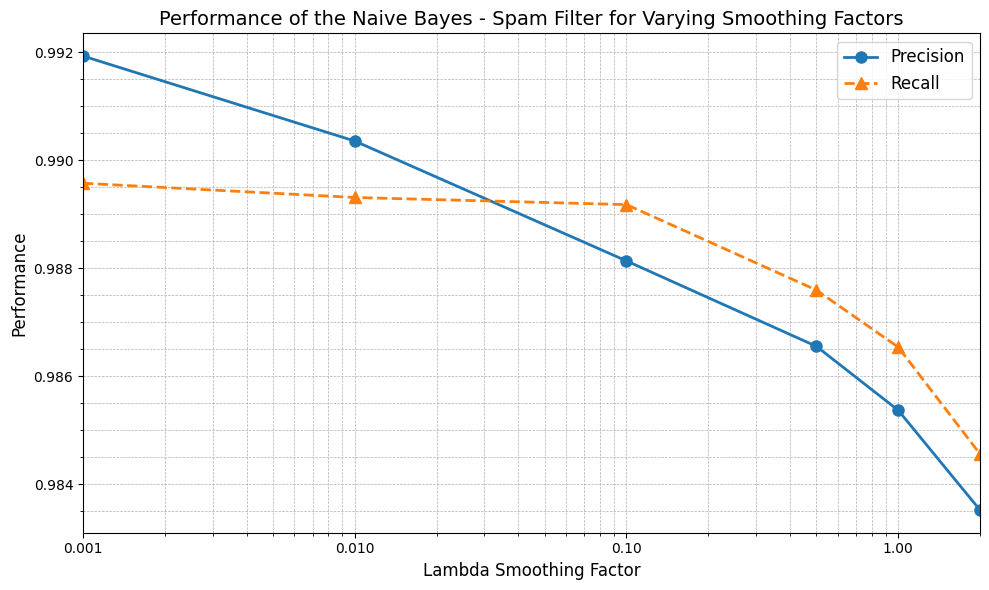

In [15]:
plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(lambda_values, precision_results, label="Precision", linestyle="-", marker="o", linewidth=2, markersize=8)
plt.plot(lambda_values, recall_results, label="Recall", linestyle="--", marker="^", linewidth=2, markersize=8)

plt.title("Performance of the Naive Bayes - Spam Filter for Varying Smoothing Factors", fontsize=14)
plt.xlabel("Lambda Smoothing Factor", fontsize=12)
plt.ylabel("Performance", fontsize=12)

plt.xscale("log")  # Logarithmic scale for x-axis

# Format x-ticks in decimal notation
def decimal_formatter(x, pos):
    return f"{x:.3f}" if x < 0.1 else f"{x:.2f}"

plt.gca().xaxis.set_major_formatter(FuncFormatter(decimal_formatter))

plt.xlim(min(lambda_values), max(lambda_values))  # Adjust x-axis limits

plt.grid(which='both', linestyle='--', linewidth=0.5)  # Adding grid
plt.minorticks_on()  # Enable minor ticks

plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()

Answer: Based on the plot above, a lower smoothing factor results in the best performance in terms of precision and recall. More specifically, a lambda smoothing value of $0.001$ maximizes both precision and recall on the test set. It can be inferred from the decreasing trend in the plot that choosing a large smoothing factor results in an underfitted classifier due to the degradation in performance. Thus, the best smoothing value is $0.001$. Additionally, it can be observed that the precision is greater than the recall of the classifier for $\lambda \leq 0.03$ while the opposite is true for $\lambda > 0.03$. This presents the fundamental trade-off between precision and recall, wherein an increase in precision results in a decrease in recall and vice versa. 

## Obtain the Top 200 Words Ranked Based on Mutual Information
Instead of frequency, mutual information score is computed for each word in the vocabulary, and this is used to rank words in the training set. Mutual information is given by:

$$
MI(X, \omega) = \Sigma_{i =1}^d \Sigma_{\omega \in \Omega} P(x_i, \omega) \log \frac{P(x_i, \omega)}{P(x_i) P(\omega)}
$$

In [22]:
# Helper function to compute MI component
def mi_component(N, n_ij, n_i_, n_j):
    if n_ij == 0:
        return 0
    else:
        return (n_ij / N) * np.log2((N * n_ij) / (n_i_ * n_j))

def compute_mutual_information(X_train, y_train):
    # Initialize counts
    N = len(X_train)  # Total number of documents
    word_counts = defaultdict(lambda: {0: 0, 1: 0})
    label_counts = Counter(y_train)
        
    # Build word-class contingency tables (Optimized)
    for words, label in zip(X_train, y_train):
        unique_words = set(words)
        for word in unique_words:
            word_counts[word][label] += 1
        
    # Compute MI for each word
    mi_scores = {}
    for word in word_counts:
        # Contingency table values
        N11 = word_counts[word][1]  # Word present, spam label
        N01 = word_counts[word][0]  # Word present, ham label
        N1_ = N11 + N01             # Word present
        N10 = label_counts[1] - N11 # Word absent, spam label
        N00 = label_counts[0] - N01 # Word absent, ham label
        N0_ = N10 + N00             # Word absent
        
        # Total counts for classes
        N_1 = label_counts[1]
        N_0 = label_counts[0]
        
        # Mutual Information components
        mi = 0
        
        # Compute MI components
        mi += mi_component(N, N11, N1_, N_1)
        mi += mi_component(N, N01, N1_, N_0)
        mi += mi_component(N, N10, N0_, N_1)
        mi += mi_component(N, N00, N0_, N_0)
        
        mi_scores[word] = mi
    return mi_scores

In [17]:
# Compute MI scores
mi_scores = compute_mutual_information(X_train, y_train)

# Sort words by MI score in descending order
sorted_words = sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)

# Get the top 200 words
i = 1
print("Top 200 Words Ranked by Mutual Information")
for word, mi_score in sorted_words[:TOP_N_WORDS]:
    print(f"{i}. {word}, Mutual Information: {mi_score}")
    i += 1

Top 200 Words Ranked by Mutual Information
1. owner, Mutual Information: 0.1670976623925281
2. unknown, Mutual Information: 0.1564959512434295
3. href, Mutual Information: 0.1525602570420208
4. list, Mutual Information: 0.13773014500303435
5. the, Mutual Information: 0.13772701895879177
6. wrote, Mutual Information: 0.13026552835640187
7. br, Mutual Information: 0.1300427565941713
8. precedence, Mutual Information: 0.1284235268824553
9. head, Mutual Information: 0.1262391832036039
10. equiv, Mutual Information: 0.12394759411309567
11. meta, Mutual Information: 0.12185019934485984
12. com, Mutual Information: 0.11763865753874762
13. border, Mutual Information: 0.11417212974828184
14. bgcolor, Mutual Information: 0.1141496992502363
15. thanks, Mutual Information: 0.11410106875778143
16. if, Mutual Information: 0.10823009057860304
17. alternative, Mutual Information: 0.10775480373754737
18. use, Mutual Information: 0.1072302084826145
19. width, Mutual Information: 0.10641007906646356
20. 

## Retrain the classifier without the top 200 words
To retrain the classifier without the top 200 words ranked by highest mutual information, remove these words from `X_train` then instantiate and train a new classifier on the reduced training set.

In [18]:
# Get the top 200 words
top_200_words = set(word for word, _ in sorted_words[:TOP_N_WORDS])

def remove_top_words(documents, top_words):
    return [[word for word in doc if word not in top_words] for doc in documents]

# Remove the top 200 words from X_train so that it does not show up in the vocabulary
X_train_reduced = remove_top_words(X_train, top_200_words)

In [19]:
# Re-initialize a Naive Bayes classifier with the best smoothing factor
nbc = NaiveBayesClassifier(smoothing_factor=1e-3)

# Train the classifier
nbc.fit(X_train_reduced, y_train)

# Predict the labels for the test set
y_pred = nbc.predict(X_test)

reduced_train_set_metrics = compute_metrics(y_test, y_pred)
print(f"Precision: {reduced_train_set_metrics['precision']}")
print(f"Recall: {reduced_train_set_metrics['recall']}")

Precision: 0.9897597479322567
Recall: 0.9949848224891118


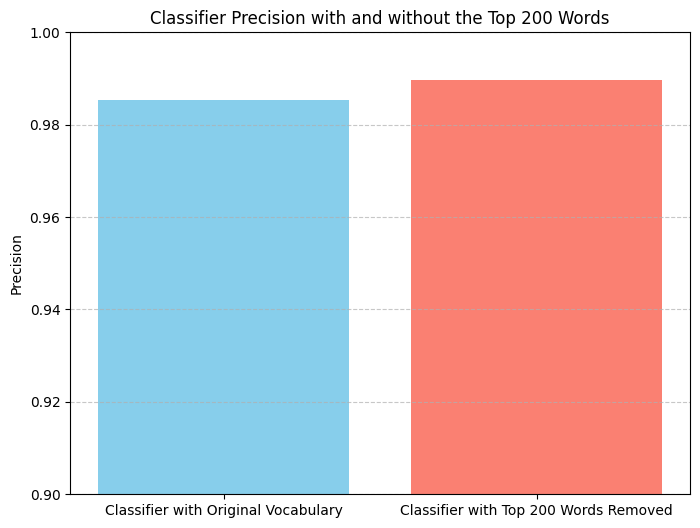

In [20]:
# Visualize comparison of precision with and without the top 200 words
models = ["Classifier with Original Vocabulary", "Classifier with Top 200 Words Removed"]
precision_scores = [initial_metrics["precision"], reduced_train_set_metrics["precision"]]

plt.figure(figsize=(8, 6))
plt.bar(models, precision_scores, color=["skyblue", "salmon"])
plt.title("Classifier Precision with and without the Top 200 Words")
plt.ylabel("Precision")
plt.ylim(0.9, 1)  # Assuming precision values range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

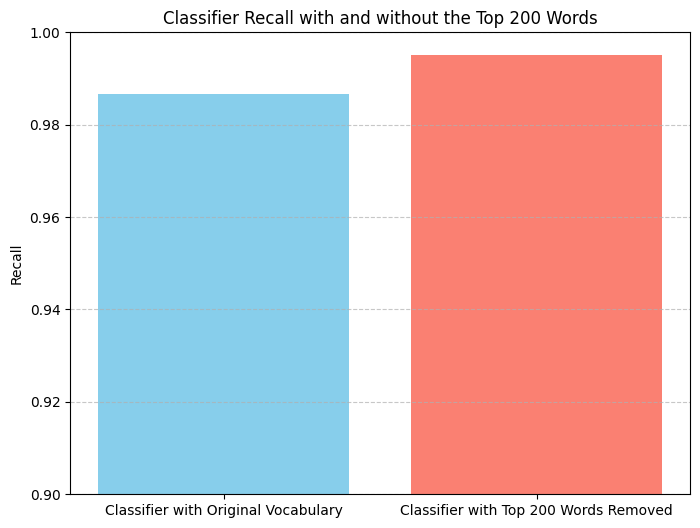

In [21]:
# Visualize comparison of recall with and without the top 200 words
models = ["Classifier with Original Vocabulary", "Classifier with Top 200 Words Removed"]
recall_scores = [initial_metrics["recall"], reduced_train_set_metrics["recall"]]

plt.figure(figsize=(8, 6))
plt.bar(models, recall_scores, color=["skyblue", "salmon"])
plt.title("Classifier Recall with and without the Top 200 Words")
plt.ylabel("Recall")
plt.ylim(0.9, 1)  # Assuming precision values range from 0 to 1
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()